In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

## Optical digits

In [2]:
train_file = './uci_repos/optical_digits/optdigits.tra'
test_file = './uci_repos/optical_digits/optdigits.tes'
column = ['pixel_'+str(i) for i in range(64)]
column.append('digit_label')
train_data = pd.read_csv(train_file, sep=',', header=None, names=column)
test_data = pd.read_csv(test_file, sep=',', header=None, names=column)

In [3]:
test_data.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_55,pixel_56,pixel_57,pixel_58,pixel_59,pixel_60,pixel_61,pixel_62,pixel_63,digit_label
0,0,0,5,13,9,1,0,0,0,0,...,0,0,0,6,13,10,0,0,0,0
1,0,0,0,12,13,5,0,0,0,0,...,0,0,0,0,11,16,10,0,0,1
2,0,0,0,4,15,12,0,0,0,0,...,0,0,0,0,3,11,16,9,0,2
3,0,0,7,15,13,1,0,0,0,8,...,0,0,0,7,13,13,9,0,0,3
4,0,0,0,1,11,0,0,0,0,0,...,0,0,0,0,2,16,4,0,0,4


In [4]:
train_y = train_data.iloc[:,-1:].copy().to_numpy()
train_images = train_data.iloc[:, 0:-1].copy().to_numpy()
test_y = test_data.iloc[:,-1:].copy().to_numpy()
test_images = test_data.iloc[:, 0:-1].copy().to_numpy()

In [5]:
np.unique(test_y)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

train image size :  (3823, 64)
train y size :  (3823, 10)
test image size :  (1797, 64)
test y size :  (1797, 10)
sample y : [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


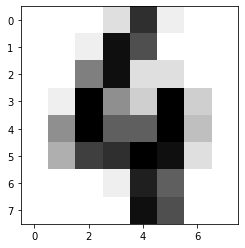

In [6]:
#train_images = [np.reshape(x, (8,8, 1)) for x in train_images ]
train_images = np.array(train_images).astype(np.float32) / 16.0
#test_images = [np.reshape(x, (8,8, 1)) for x in test_images ]
test_images = np.array(test_images).astype(np.float32) / 16.0

train_y = tf.keras.utils.to_categorical(train_y, num_classes=10, dtype='float32')
test_y = tf.keras.utils.to_categorical(test_y, num_classes=10, dtype='float32')
print('train image size : ', train_images.shape)
print('train y size : ', train_y.shape)
print('test image size : ', test_images.shape)
print('test y size : ', test_y.shape)
print('sample y :', train_y[0])
plt.imshow(np.reshape(train_images[100],(8,8)), cmap=plt.cm.gray_r, interpolation='nearest')

### VAE

In [7]:
import tensorflow.compat.v1  as tf
tf.disable_v2_behavior()
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np

mb_size = 64
z_dim = 100
X_dim = 64
y_dim = 10
h_dim = 128
lr = 1e-3


def plot(samples):
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(8, 8)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(8, 8), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev)


# Q(z|X) 

X = tf.keras.Input(shape=(X_dim,))
c = tf.keras.Input(shape=(y_dim,))
z = tf.keras.Input(shape=(z_dim,))

Q_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, c):
    inputs = tf.concat(axis=1, values=[X, c])
    h = tf.nn.relu(tf.matmul(inputs, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


# P(X|z)

P_W1 = tf.Variable(xavier_init([z_dim + y_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    h = tf.nn.relu(tf.matmul(inputs, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

z_mu, z_logvar = Q(X, c)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample, c)

# Sampling from random z
X_samples, _ = P(z, c)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

# gradient step
solver = tf.compat.v1.train.AdamOptimizer().minimize(vae_loss)
sess = tf.compat.v1.Session ()
sess.run(
tf.compat.v1.global_variables_initializer())

if not os.path.exists('samples/'):
    os.makedirs('samples/')

i = 0

for it in range(100000):
    ind = np.random.choice(train_images.shape[0], mb_size)
    X_mb = np.array(train_images[ind])
    y_mb = np.array(train_y[ind])
    
    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb, c: y_mb})

    if it % 1000 == 0:
        print('Iter: {}'.format(it))
        print('Loss: {:.2}'. format(loss))
        print()

        y = np.zeros(shape=[64, y_dim])
        y[:, np.random.randint(0, y_dim)] = 1.

        samples = sess.run(X_samples,
                           feed_dict={z: np.random.randn(64, z_dim), c: y})

        fig = plot(samples)
        plt.savefig('samples/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)



Instructions for updating:
non-resource variables are not supported in the long term


2021-09-20 16:31:20.800386: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-09-20 16:31:20.832884: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-09-20 16:31:20.839453: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-09-20 16:31:20.840805: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

Iter: 0
Loss: 8.1e+01

Iter: 1000
Loss: 2.2e+01

Iter: 2000
Loss: 2.2e+01

Iter: 3000
Loss: 2.2e+01

Iter: 4000
Loss: 2.1e+01

Iter: 5000
Loss: 2.2e+01

Iter: 6000
Loss: 2.2e+01

Iter: 7000
Loss: 2.2e+01

Iter: 8000
Loss: 2.2e+01

Iter: 9000
Loss: 2.1e+01

Iter: 10000
Loss: 2.2e+01

Iter: 11000
Loss: 2.1e+01

Iter: 12000
Loss: 2e+01

Iter: 13000
Loss: 2.1e+01

Iter: 14000
Loss: 2.1e+01

Iter: 15000
Loss: 2.1e+01

Iter: 16000
Loss: 2.1e+01

Iter: 17000
Loss: 2.1e+01

Iter: 18000
Loss: 2.1e+01

Iter: 19000
Loss: 2e+01

Iter: 20000
Loss: 2.1e+01

Iter: 21000
Loss: 2.1e+01

Iter: 22000
Loss: 2e+01

Iter: 23000
Loss: 2e+01

Iter: 24000
Loss: 2.1e+01

Iter: 25000
Loss: 2e+01

Iter: 26000
Loss: 2e+01

Iter: 27000
Loss: 2.1e+01

Iter: 28000
Loss: 2.1e+01

Iter: 29000
Loss: 2.1e+01

Iter: 30000
Loss: 2e+01

Iter: 31000
Loss: 2.1e+01

Iter: 32000
Loss: 2e+01

Iter: 33000
Loss: 2.1e+01

Iter: 34000
Loss: 2.1e+01

Iter: 35000
Loss: 2e+01

Iter: 36000
Loss: 2.1e+01

Iter: 37000
Loss: 2.1e+01

Iter:

In [8]:
### generating sample outputs after training
samples = []
gen_labels =[]
for r in range(10):
    for index in range(10):
        gen_labels = gen_labels + [index]*64
        y = np.zeros([mb_size, y_dim])
        y[range(mb_size), index] = 1
        samples.extend(sess.run(X_samples,
                               feed_dict={z: np.random.randn(64, z_dim), c: y}))

gen_samples = np.array(samples)
gen_labels = np.array(gen_labels)

In [9]:
gen_samples.shape, gen_labels.shape

((6400, 64), (6400,))

In [10]:
gen_samples[0]

array([1.7222977e-11, 2.1757185e-03, 2.9612523e-01, 8.3878410e-01,
       6.0361630e-01, 1.0099074e-01, 1.3523698e-03, 3.4047559e-07,
       5.8265395e-25, 9.1162026e-02, 8.5198128e-01, 8.1891137e-01,
       7.5861585e-01, 6.1310613e-01, 2.8289467e-02, 1.6366903e-05,
       1.1734277e-19, 2.8079912e-01, 8.9631152e-01, 2.5558442e-01,
       1.9316033e-01, 7.9490685e-01, 1.8244934e-01, 9.9386190e-05,
       4.2239124e-22, 3.5566106e-01, 8.1117821e-01, 7.7774584e-02,
       2.0422906e-02, 5.7483554e-01, 4.2295396e-01, 1.1273197e-05,
       3.8720616e-10, 4.3737295e-01, 8.0540490e-01, 4.1941643e-02,
       1.1087775e-02, 4.9869877e-01, 4.9771443e-01, 1.7904280e-11,
       4.4046047e-08, 2.6993269e-01, 8.7325299e-01, 6.2076300e-02,
       3.8056850e-02, 6.5051734e-01, 4.6573162e-01, 8.2685174e-06,
       8.2425595e-06, 5.2448630e-02, 8.4142536e-01, 6.0340798e-01,
       6.0490954e-01, 9.0616459e-01, 1.9552082e-01, 7.9266676e-05,
       1.1562824e-23, 9.0473890e-04, 2.6234663e-01, 8.6221576e

1


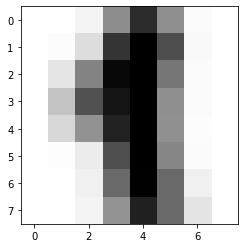

In [39]:
print(gen_labels[70])
plt.imshow(np.reshape(gen_samples[70],(8,8)), cmap=plt.cm.gray_r, interpolation='nearest')

In [12]:
np.save('gen_data.npy', gen_samples)
np.save('gen_labels.npy', gen_labels)

# 1. Experimenting on original samples only with RF (Baseline)

In [13]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth=2, random_state=0)

y_train = train_data.iloc[:,-1:].copy().to_numpy()
x_train = train_data.iloc[:, 0:-1].copy().to_numpy()
y_test = test_data.iloc[:,-1:].copy().to_numpy()
x_test = test_data.iloc[:, 0:-1].copy().to_numpy()


In [14]:
rf.fit(x_train, y_train)
rf.score(x_test, y_test)

/tmp/ipykernel_26606/147419484.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


0.800222593210907

In [15]:
pred_y = rf.predict(x_test)

In [16]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred_y))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       178
           1       0.77      0.43      0.55       182
           2       0.76      0.84      0.79       177
           3       0.71      0.90      0.79       183
           4       0.88      0.81      0.84       181
           5       0.93      0.71      0.81       182
           6       0.80      0.97      0.88       181
           7       0.75      0.92      0.83       179
           8       0.74      0.65      0.69       174
           9       0.80      0.78      0.79       180

    accuracy                           0.80      1797
   macro avg       0.81      0.80      0.79      1797
weighted avg       0.81      0.80      0.79      1797



In [17]:
x_train[1]

array([ 0,  0, 10, 16,  6,  0,  0,  0,  0,  7, 16,  8, 16,  5,  0,  0,  0,
       11, 16,  0,  6, 14,  3,  0,  0, 12, 12,  0,  0, 11, 11,  0,  0, 12,
       12,  0,  0,  8, 12,  0,  0,  7, 15,  1,  0, 13, 11,  0,  0,  0, 16,
        8, 10, 15,  3,  0,  0,  0, 10, 16, 15,  3,  0,  0])

## 2. Generated samples classification (only)

In [18]:
from sklearn.model_selection import train_test_split
x_gentrain,x_gentest, y_gentrain, y_gentest = train_test_split(
    gen_samples, gen_labels, test_size=0.25, random_state=42)


rf1 = RandomForestClassifier(max_depth=2, random_state=0)
rf1.fit(x_gentrain, y_gentrain)
rf1.score(x_gentest, y_gentest)

0.98375

In [19]:
pred_ygen = rf1.predict(x_gentest)
print(classification_report(y_gentest, pred_ygen))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       164
           1       1.00      0.95      0.97       180
           2       0.98      0.99      0.98       150
           3       0.99      1.00      1.00       171
           4       1.00      0.94      0.97       142
           5       1.00      0.97      0.99       154
           6       0.97      1.00      0.99       167
           7       0.99      0.99      0.99       155
           8       1.00      0.99      1.00       159
           9       0.91      1.00      0.95       158

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



## Discussion (Why High Accuracy)

The classification result on generated samples appeared higher by over 18 %. Next we try to normalize pixels before classification just to cverify that the results are not affected by the pixel values.


In [20]:
# normiziling pixel between 0..16 similar to the original data.
norm_xtrain = (16*(x_gentrain - np.min(x_gentrain))/np.ptp(x_gentrain)).astype(int) 
norm_xtest = (16*(x_gentest - np.min(x_gentest))/np.ptp(x_gentest)).astype(int) 

5


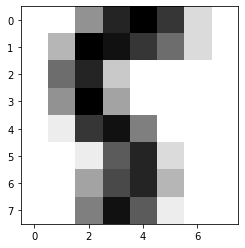

In [47]:
print(y_gentrain[1008])
plt.imshow(np.reshape(norm_xtrain[1008],(8,8)), cmap=plt.cm.gray_r, interpolation='nearest')

In [22]:
rf2 = RandomForestClassifier(max_depth=2, random_state=0)
rf2.fit(norm_xtrain, y_gentrain)
rf2.score(norm_xtest, y_gentest)

0.978125

In [23]:
pred_norm = rf2.predict(norm_xtest)
print(classification_report(y_gentest, pred_norm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       164
           1       1.00      0.97      0.98       180
           2       0.99      0.96      0.97       150
           3       0.96      0.99      0.98       171
           4       1.00      0.92      0.96       142
           5       0.99      0.97      0.98       154
           6       0.98      1.00      0.99       167
           7       0.99      0.99      0.99       155
           8       0.99      0.99      0.99       159
           9       0.90      0.98      0.94       158

    accuracy                           0.98      1600
   macro avg       0.98      0.98      0.98      1600
weighted avg       0.98      0.98      0.98      1600



The results appeared unchanged. Thus, pixel values/norm had zero effect on the results.

## 3.  Trained on real testing on generated

In [24]:
print('test accuracy : ', rf.score(norm_xtest, y_gentest))

test accuracy :  0.916875


In [25]:
pred_norm3 = rf.predict(norm_xtest)
print(classification_report(y_gentest, pred_norm3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       164
           1       1.00      0.59      0.75       180
           2       0.88      0.95      0.91       150
           3       0.85      0.96      0.90       171
           4       0.99      0.92      0.95       142
           5       0.99      0.81      0.89       154
           6       0.95      1.00      0.97       167
           7       0.90      1.00      0.95       155
           8       0.82      1.00      0.90       159
           9       0.88      0.97      0.92       158

    accuracy                           0.92      1600
   macro avg       0.93      0.92      0.91      1600
weighted avg       0.93      0.92      0.91      1600



## 4. Trained on generated --> testing on real

In [26]:
print('test accuracy : ', rf2.score(x_test, y_test))

test accuracy :  0.7401224262659989


In [27]:
pred_y4 = rf2.predict(x_test)
print(classification_report(y_test, pred_y4))

              precision    recall  f1-score   support

           0       0.81      0.97      0.88       178
           1       0.48      0.82      0.61       182
           2       0.77      0.66      0.71       177
           3       0.76      0.76      0.76       183
           4       0.81      0.80      0.80       181
           5       0.82      0.80      0.81       182
           6       0.80      0.97      0.88       181
           7       0.80      0.74      0.77       179
           8       0.83      0.40      0.54       174
           9       0.76      0.47      0.58       180

    accuracy                           0.74      1797
   macro avg       0.76      0.74      0.73      1797
weighted avg       0.76      0.74      0.73      1797



## Discussion 

The results indicated that the original samples where more difficult to classify. Performances where both diminishing whether the model was trained on original or generated sample.

## 5. Combine train from generated and real samples

In [28]:
X = np.concatenate([x_train, norm_xtrain])
Y = np.concatenate([np.reshape(y_train, -1), y_gentrain])

RF = RandomForestClassifier(max_depth=2, random_state=0)
RF.fit(X, Y)

RandomForestClassifier(max_depth=2, random_state=0)

In [29]:
print('Real test accuracy : ', RF.score(x_test, y_test))
print('Generated accuracy : ', RF.score(norm_xtest, y_gentest))

Real test accuracy :  0.7941012799109627
Generated accuracy :  0.9575


In [30]:
pred_y5 = RF.predict(x_test)
print('real classification report\n',classification_report(y_test, pred_y5))

real classification report
               precision    recall  f1-score   support

           0       0.88      0.98      0.93       178
           1       0.80      0.38      0.51       182
           2       0.68      0.90      0.78       177
           3       0.74      0.91      0.81       183
           4       0.83      0.83      0.83       181
           5       0.86      0.84      0.85       182
           6       0.78      0.97      0.87       181
           7       0.82      0.91      0.86       179
           8       0.79      0.50      0.61       174
           9       0.80      0.71      0.75       180

    accuracy                           0.79      1797
   macro avg       0.80      0.79      0.78      1797
weighted avg       0.80      0.79      0.78      1797



In [31]:
pred_y5g = RF.predict(norm_xtest)
print('generated classification report\n',classification_report(y_gentest, pred_y5g))

generated classification report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       164
           1       1.00      0.80      0.89       180
           2       0.98      0.96      0.97       150
           3       0.93      0.99      0.96       171
           4       1.00      0.92      0.96       142
           5       0.98      0.94      0.96       154
           6       0.96      1.00      0.98       167
           7       0.95      1.00      0.97       155
           8       0.90      0.99      0.94       159
           9       0.91      0.98      0.95       158

    accuracy                           0.96      1600
   macro avg       0.96      0.96      0.96      1600
weighted avg       0.96      0.96      0.96      1600



In [32]:
##combine test results
x = np.concatenate([x_test, norm_xtest])
y = np.concatenate([np.reshape(y_test, -1), y_gentest])

In [33]:
print('Combined Accuracy : ', RF.score(x, y))
pred_y5c = RF.predict(x)
print('Combined classification report\n',classification_report(y, pred_y5c))

Combined Accuracy :  0.8710627023844568
Combined classification report
               precision    recall  f1-score   support

           0       0.94      0.99      0.96       342
           1       0.93      0.59      0.72       362
           2       0.80      0.93      0.86       327
           3       0.82      0.95      0.88       354
           4       0.90      0.87      0.89       323
           5       0.91      0.89      0.90       336
           6       0.86      0.99      0.92       348
           7       0.88      0.95      0.91       334
           8       0.86      0.73      0.79       333
           9       0.86      0.83      0.85       338

    accuracy                           0.87      3397
   macro avg       0.87      0.87      0.87      3397
weighted avg       0.87      0.87      0.87      3397

